In [1]:
import heeps
from heeps.wavefront.get_array import show_wf
from heeps.util.multiCPU import multiCPU
from astropy.io import fits
import numpy as np
from copy import deepcopy
import os
import proper.prop_get_amplitude as get_amp
import matplotlib.pyplot as plt
%matplotlib inline

### Inputs

(10526, 10526)

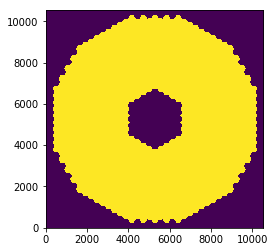

In [2]:
nr = 30
nt = 45
rs = np.linspace(0.45, 0.65, nr)    # RAP r values
ts = np.linspace(0.6, 0.9, nt)      # RAP t values
pupil_img_size = 39.9988
diam_ext = 36.905                   # all-glass diameters
diam_int = 11.213
diam_nom_ext = 38.542               # nominal diameters
diam_nom_int = 10.952
diam_dodecagon = 36.8765            # dodecagon diameters (cf. create_lyotstops.ipynb)
diam_hexagon = 11.6081
dir_output = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/ravc_optim'))
dir_pupil = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil'))
pup = fits.getdata(os.path.join(dir_pupil, 'eso/mask_fullM1.fits'))
plt.imshow(pup, origin='lower')
pup.shape

### Find RAP (ring apodizer) parameters

In [3]:
# central obscuration radius, using all-glass pupil diameters
r_ag = diam_int/diam_ext
ra_t0 = 1 - (r_ag**2 + r_ag*np.sqrt(r_ag**2 + 8))/4
ra_r0 = r_ag/np.sqrt(1 - ra_t0)
# central obscuration radius, using nominal pupil diameters
r_nom = diam_nom_int/diam_nom_ext
ra_t1 = 1 - (r_nom**2 + r_nom*np.sqrt(r_nom**2 + 8))/4
ra_r1 = r_nom/np.sqrt(1 - ra_t1)
# calculate radius wrt 'allglass' diameter
ra_r1 *= diam_nom_ext/diam_ext
# central obscuration radius, using dodecagon pupil diameters
r_dod = diam_hexagon/diam_dodecagon
ra_t2 = 1 - (r_dod**2 + r_dod*np.sqrt(r_dod**2 + 8))/4
ra_r2 = r_dod/np.sqrt(1 - ra_t2)
# calculate radius wrt 'allglass' diameter
ra_r2 *= diam_dodecagon/diam_ext
# calculate mean M1 diameter values
nimg = pup.shape[0]
pup_range = np.arange(-1, 1, 2/nimg) + 1/nimg
xi,yi = np.meshgrid(pup_range, pup_range)
ri = np.abs(xi + 1j*yi)
tota_area = nimg**2
outer_area = np.sum((1-pup)[ri>0.5])
inner_area = np.sum((1-pup)[ri<0.5])
r_ext = np.sqrt((tota_area - outer_area)/np.pi)
r_int = np.sqrt(inner_area/np.pi)
# average M1 diam (calculated)
diam_ext_M1 = 2*r_ext/nimg*pupil_img_size
diam_int_M1 = 2*r_int/nimg*pupil_img_size
# central obscuration radius, using mean diameters
r_obstr = diam_int_M1/diam_ext_M1
ra_t3 = 1 - (r_obstr**2 + r_obstr*np.sqrt(r_obstr**2 + 8))/4
ra_r3 = r_obstr/np.sqrt(1 - ra_t3)
# calculate radius wrt 'allglass' diameter
ra_r3 *= diam_ext_M1/diam_ext
print('for all-glass diameters:\n   ra_t0 = %.3f, ra_r0 = %.3f'%(ra_t0, ra_r0))
print('for nominal diameters:\n   ra_t1 = %.3f, ra_r1 = %.3f'%(ra_t1, ra_r1))
print('for dodecagon diameters:\n   ra_t2 = %.3f, ra_r2 = %.3f'%(ra_t2, ra_r2))
print('for average M1 diam:\n   diam_ext_M1 = %.3f\n   diam_int_M1 = %.3f'
    %(diam_ext_M1, diam_int_M1))
print('   ra_t3 = %.3f, ra_r3 = %.3f'%(ra_t3, ra_r3))

for all-glass diameters:
   ra_t0 = 0.761, ra_r0 = 0.621
for nominal diameters:
   ra_t1 = 0.778, ra_r1 = 0.630
for dodecagon diameters:
   ra_t2 = 0.751, ra_r2 = 0.631
for average M1 diam:
   diam_ext_M1 = 37.812
   diam_int_M1 = 10.196
   ra_t3 = 0.790, ra_r3 = 0.603


In [4]:
def get_contrast_thruput(conf, wf, r, t):
    verbose = False
    conf['ravc_r'] = r
    conf['ravc_t'] = t
    wf1 = heeps.optics.apodizer(deepcopy(wf), verbose=verbose, **conf)
    wf2 = heeps.optics.lyot_stop(deepcopy(wf1), verbose=verbose, **conf)
    T = np.sum(get_amp(wf2)**2)
    wf1 = heeps.optics.fp_mask(wf1, verbose=verbose, **conf)
    wf1 = heeps.optics.lyot_stop(wf1, verbose=verbose, **conf)
    C = np.sum(get_amp(wf1)**2)        
    return C, T

def get_C_T_CT2(conf, wf, case, rs, ts):
    if os.path.isfile(os.path.join(dir_output, case + '_T.fits')):
        C = fits.getdata(os.path.join(dir_output, case + '_C.fits'))
        T = fits.getdata(os.path.join(dir_output, case + '_T.fits'))
    else:
        C, T = multiCPU(get_contrast_thruput, nout=2, posargs=[conf, wf], 
            posvars=[np.repeat(rs, len(ts)), np.tile(ts, len(rs))])
        C = C.reshape(nr, nt)
        T = T.reshape(nr, nt)
        fits.writeto(os.path.join(dir_output, case + '_C.fits'), C)
        fits.writeto(os.path.join(dir_output, case + '_T.fits'), T)
    CT2 = C/T**2
    return C, T, CT2
    
def optim_C_T_CT2(C, T, CT2):
    best_C = []
    best_T = []
    best_CT2 = []
    t_C = []
    t_T = []
    t_CT2 = []
    (ny, nx) = CT2.shape
    for i in range(ny):
        for j in range(nx):
            if j==0:
                best_C.append(C[i,j])
                best_T.append(T[i,j])
                best_CT2.append(CT2[i,j])
                t_C.append(j)
                t_T.append(j)
                t_CT2.append(j)
            else:
                if C[i,j] < best_C[-1]:
                    best_C[-1] = C[i,j]
                    t_C[-1] = j
                if T[i,j] > best_T[-1]:
                    best_T[-1] = T[i,j]
                    t_T[-1] = j
                if CT2[i,j] < best_CT2[-1]:
                    best_CT2[-1] = CT2[i,j]
                    t_CT2[-1] = j
    return t_C, t_T, t_CT2

def plot_2d_map(rs, ts, t0, arr, case, title):
    extent = (ts[0], ts[-1], rs[0], rs[-1])
    plt.imshow(np.log10(arr), origin='lower', extent=extent, aspect='auto')
    plt.colorbar()
    plt.plot(ts[t0], rs, c='yellow')
    plt.scatter(ra_t0, ra_r0, s=150, c='red', marker='+')
    plt.scatter(ra_t3, ra_r3, s=150, c='orange', marker='+')
    ind_min = np.unravel_index(np.argmin(arr, axis=None), arr.shape)
    x, y = ind_min[0], ind_min[1]
    plt.scatter(ts[y], rs[x], s=150, c='yellow', marker='+')
    plt.xlim(ts[0], ts[-1])
    plt.ylim(rs[0], rs[-1])
    plt.xlabel('t_ravc');
    plt.ylabel('r_ravc');
    plt.title(title);
    plt.savefig(os.path.join(dir_output, case + '_' + title.replace('/', '_') + '.png'))
    print('optimum = %.4f (t=%.4f, r=%.4f)'%(arr[x, y], ts[y], rs[x]))

# All-glass (no spider, no segment)

In [5]:
conf = dict(
    f_pupil = '',
    spi_width = 0,
    seg_width = 0,
    ngrid = 2**11,
    f_lyot_stop = '',
    ls_dRext = 0,
    ls_dRint = 0,
    ls_dRspi = 0,
    ravc_calc = False,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(verbose=True, **conf)

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=2048, diam_norm=1.0838, beam_ratio=0.2572
   ravc_calc=False, ravc_t=0.7450, ravc_r=0.5050
   npupil=571, pscale=5.47 mas, lam=3.8045E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.83 lam/D)

Create pupil: spi_width=0 m, seg_width=0 m, seg_gap=0.004 m, seg_rms=0


445.25775172831317

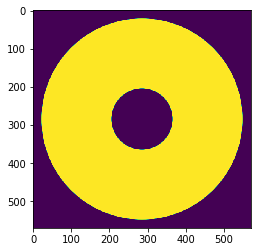

In [6]:
from heeps.util.img_processing import crop_img
plt.imshow(crop_img(get_amp(wf), 571))
np.sum(get_amp(wf))

In [7]:
case = 'allglassNOspi_nt=%s_nr=%s'%(nt, nr)
C, T, CT2 = get_C_T_CT2(conf, wf, case, rs, ts)
t_C, t_T, t_CT2 = optim_C_T_CT2(C, T, CT2)

   2022-03-28 19:37:56, using 56 cores
   2022-03-28 19:50:49, completed in 773.14 seconds


optimum = 0.0002 (t=0.6068, r=0.4845)


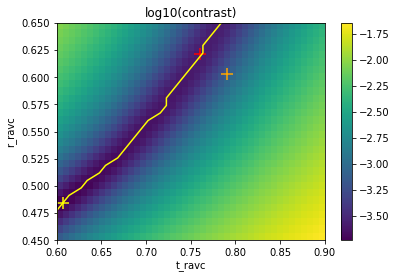

In [8]:
plot_2d_map(rs, ts, t_C, C, case, 'log10(contrast)')

optimum = 0.2292 (t=0.6000, r=0.6500)


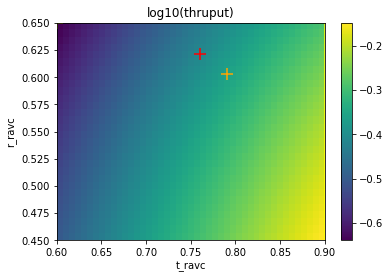

In [9]:
plot_2d_map(rs, ts, t_T, T, case, 'log10(thruput)')

optimum = 0.0016 (t=0.7159, r=0.5672)


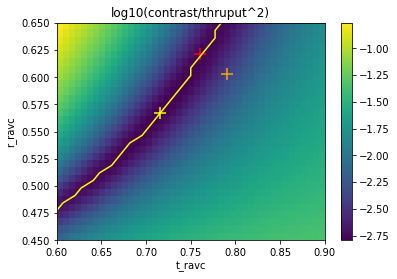

In [10]:
plot_2d_map(rs, ts, t_CT2, CT2, case, 'log10(contrast/thruput^2)')

# All-glass

In [11]:
conf = dict(
    f_pupil = 'pupil/ELT_allglass.fits',
    ngrid = 2**11,
    f_lyot_stop = '',
    ls_dRext = 0,
    ls_dRint = 0,
    ls_dRspi = 0,
    ravc_calc = False,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(verbose=True, **conf)

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=2048, diam_norm=1.0838, beam_ratio=0.2572
   ravc_calc=False, ravc_t=0.7450, ravc_r=0.5050
   npupil=571, pscale=5.47 mas, lam=3.8045E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.83 lam/D)

Load pupil from 'ELT_allglass.fits'


437.549352228124

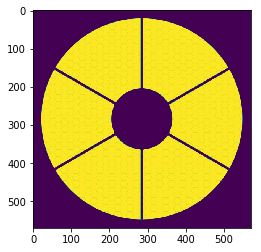

In [12]:
plt.imshow(crop_img(get_amp(wf), 571))
np.sum(get_amp(wf))

In [13]:
case = 'allglass_nt=%s_nr=%s'%(nt, nr)
C, T, CT2 = get_C_T_CT2(conf, wf, case, rs, ts)
t_C, t_T, t_CT2 = optim_C_T_CT2(C, T, CT2)

   2022-03-28 19:50:51, using 56 cores
   2022-03-28 20:09:09, completed in 1097.48 seconds


optimum = 0.0009 (t=0.6000, r=0.4638)


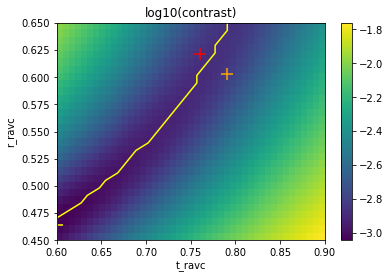

In [14]:
plot_2d_map(rs, ts, t_C, C, case, 'log10(contrast)')

optimum = 0.2296 (t=0.6000, r=0.6500)


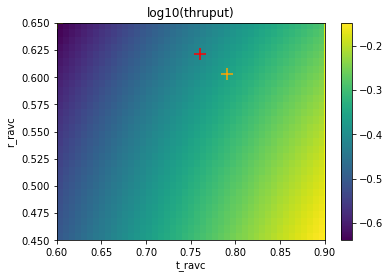

In [15]:
plot_2d_map(rs, ts, t_T, T, case, 'log10(thruput)')

optimum = 0.0074 (t=0.7432, r=0.5672)


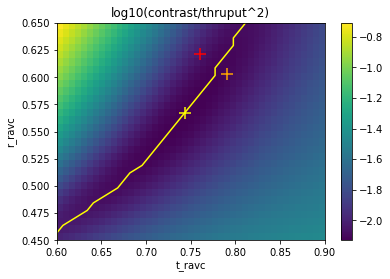

In [16]:
plot_2d_map(rs, ts, t_CT2, CT2, case, 'log10(contrast/thruput^2)')

# Full M1

In [17]:
conf = dict(
    f_pupil = 'pupil/ELT_fullM1.fits',
    ngrid = 2**11,
    f_lyot_stop = '',
    ls_dRext = 0,#(diam_ext - diam_dodecagon)/diam_nom_ext,
    ls_dRint = 0,
    ls_dRspi = 0,
    ls_ext_circ = False,
    ravc_calc = False,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(verbose=True, **conf)

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=2048, diam_norm=1.0838, beam_ratio=0.2572
   ravc_calc=False, ravc_t=0.7450, ravc_r=0.5050
   npupil=571, pscale=5.47 mas, lam=3.8045E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.83 lam/D)

Load pupil from 'ELT_fullM1.fits'


In [18]:
case = 'fullM1_nt=%s_nr=%s'%(nt, nr)
C, T, CT2 = get_C_T_CT2(conf, wf, case, rs, ts)
t_C, t_T, t_CT2 = optim_C_T_CT2(C, T, CT2)

optimum = 0.0030 (t=0.6341, r=0.4500)


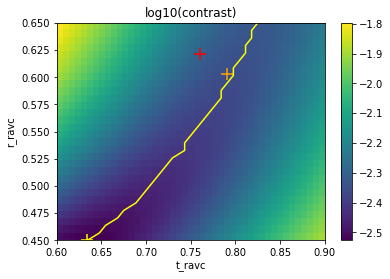

In [19]:
plot_2d_map(rs, ts, t_C, C, case, 'log10(contrast)')

optimum = 0.2237 (t=0.6000, r=0.6500)


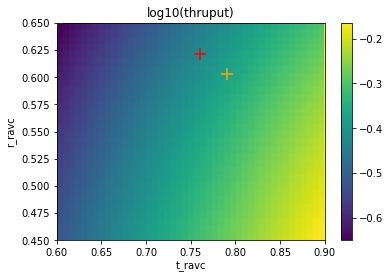

In [20]:
plot_2d_map(rs, ts, t_T, T, case, 'log10(thruput)')

optimum = 0.0190 (t=0.7909, r=0.5190)


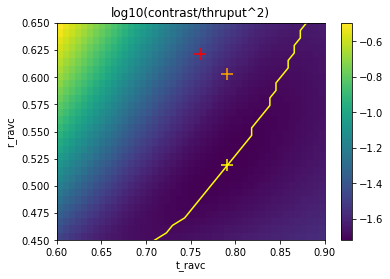

In [21]:
plot_2d_map(rs, ts, t_CT2, CT2, case, 'log10(contrast/thruput^2)')

# Full M1 (tight Lyot stop)

In [22]:
conf = dict(
    f_pupil = 'pupil/ELT_fullM1.fits',
    ngrid = 2**11,
    f_lyot_stop = '',
    ls_dRext = (diam_ext - diam_dodecagon)/diam_nom_ext,
    ls_dRint = 0,
    ls_dRspi = 0,
    ls_ext_circ = False,
    ravc_calc = False,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(verbose=True, **conf)

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=2048, diam_norm=1.0838, beam_ratio=0.2572
   ravc_calc=False, ravc_t=0.7450, ravc_r=0.5050
   npupil=571, pscale=5.47 mas, lam=3.8045E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.83 lam/D)

Load pupil from 'ELT_fullM1.fits'


In [23]:
case = 'fullM1tight_nt=%s_nr=%s'%(nt, nr)
C, T, CT2 = get_C_T_CT2(conf, wf, case, rs, ts)
t_C, t_T, t_CT2 = optim_C_T_CT2(C, T, CT2)

optimum = 0.0029 (t=0.6341, r=0.4500)


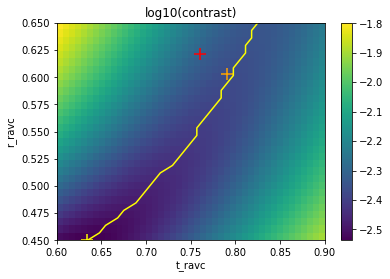

In [24]:
plot_2d_map(rs, ts, t_C, C, case, 'log10(contrast)')

optimum = 0.2234 (t=0.6000, r=0.6500)


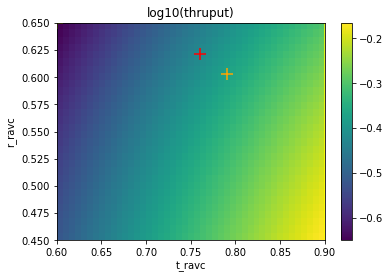

In [25]:
plot_2d_map(rs, ts, t_T, T, case, 'log10(thruput)')

optimum = 0.0186 (t=0.7909, r=0.5190)


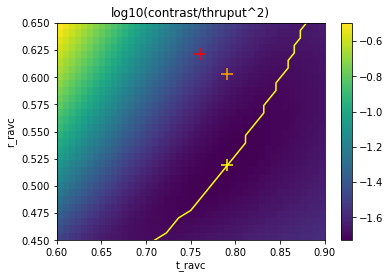

In [26]:
plot_2d_map(rs, ts, t_CT2, CT2, case, 'log10(contrast/thruput^2)')

In [27]:
rs[10], ts[t_CT2[10]], ts[t_C[10]]

(0.5189655172413793, 0.7909090909090909, 0.7295454545454545)

In [28]:
C[10, t_CT2[10]]

0.00437895850874496

In [29]:
C[10, t_C[10]]

0.003661903020945479